The following project builds on the work of Adrian Rosebrock at 
[pyimagesearch](https://www.pyimagesearch.com/2016/10/03/bubble-sheet-multiple-choice-scanner-and-test-grader-using-omr-python-and-opencv/), who created a scanner and test grader using OMR, Python, and OpenCV. This project implements the following enhancements from Adrian's version:
- Grades a more useful test sheet with a student id section (0-99) and 45 multiple choice questions (A-D).
- Grades a test sheet in an image even with light shadow effects.
- Grades questions with no bubble filled in or with more than one bubble filled in as incorrect.

In [1]:
# Import packages
from imutils.perspective import four_point_transform
import matplotlib.pyplot as plt
from imutils import contours
import random
import numpy as np
import argparse
import imutils
import cv2

%matplotlib inline

In [2]:
# Define a random answer key which maps the question number
# to the correct answer
ANSWER_KEY={}
for i in range(45):
    ANSWER_KEY[i]=random.choice([0,1,2,3])

In [3]:
# Load the image, convert it to grayscale, blur it slightly, find edges, and dilate
image = cv2.imread('./optical-mark-recognition/images2/IMG_0683.JPG')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 75, 120)

kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
dilated = cv2.dilate(edged,kernel,iterations = 8) # dilate

In [4]:
# Plot the dilated image
# fig, ax = plt.subplots(figsize=(12,12))
# plt.imshow(dilated,cmap='gray')
# plt.show()

In [5]:
# Find contours in the edge map, then initialize the contour that corresponds to the document
cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]
docCnt = None

In [6]:
# Ensure that at least one contour was found
if len(cnts) > 0:
    # Sort the contours according to their size in
    # descending order
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

    # Loop over the sorted contours
    for c in cnts:
        # Approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        # If our approximated contour has four points, then we can assume we have found the paper
        if len(approx) == 4:
            docCnt = approx
            break

# Print the document contents to ensure a document was identified
docCnt

array([[[ 142,  183]],

       [[ 137, 3767]],

       [[2896, 3827]],

       [[2957,  220]]], dtype=int32)

In [7]:
# Apply a four point perspective transform to both the
# original image and grayscale image to obtain a top-down
# birds eye view of the paper
paper = four_point_transform(image, docCnt.reshape(4, 2))
warped = four_point_transform(gray, docCnt.reshape(4, 2))

# Apply adaptive thresholding with gaussian weighted average to binarize the warped and blurred piece of paper
blurred = cv2.GaussianBlur(warped, (25, 25), 0)
thresh=cv2.adaptiveThreshold(blurred,250,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,1001,12)

# Find edges in the warped image and dilate
edged = cv2.Canny(warped, 75, 120)
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
dilated = cv2.dilate(edged,kernel,iterations = 4) # dilate

In [8]:
# Plot the dilated image
# fig, ax = plt.subplots(figsize=(12,12))
# plt.imshow(dilated,cmap='gray')
# plt.show()

In [9]:
# Find contours in the thresholded image
cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]


In [10]:
# Initialize the list to contain the contours of the ids and questions.
questionCnts = []

# Loop over the contours
for c in cnts:
    # Compute the bounding box of the contour, then use the
    # bounding box to derive the aspect ratio
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)

    # In order to label the contour as a question, region
    # should be sufficiently wide, sufficiently tall, and
    # have an aspect ratio approximately equal to 1
    if w >= 100 and h >= 100 and ar >= 0.9 and ar <= 1.1:
        questionCnts.append(c)

# Draw contours and plot to see the result
#cv2.drawContours(paper, questionCnts, -1, (0,255,0), 3)
# fig, ax = plt.subplots(figsize=(12,12))
# plt.imshow(paper,cmap='gray')
# plt.show()

In [11]:
# Verify that the total number of question contours is equal to 200
len(questionCnts)

200

In [12]:
# Sort the question contours top-to-bottom,
questionCnts = contours.sort_contours(questionCnts,method="top-to-bottom")[0]

In [13]:
# Identify the id number in each id grouping. 
id1=None
id2=None

# Sort each row of contours from left to right
for (index,value) in enumerate(np.arange(0,20,10)):
    cnts=contours.sort_contours(questionCnts[value:value+10])[0]

    fill_count=0
    
    # Construct a mask that reveals only the current
    # "bubble" for the question
    for (index2, value2) in enumerate(cnts):
        mask=np.zeros(thresh.shape,dtype="uint8")
        cv2.drawContours(mask,[value2],-1,255,-1)

        # Apply the mask to the thresholded image, then
        # count the number of non-zero pixels in the
        # bubble area
        mask=cv2.bitwise_and(thresh,thresh,mask=mask)
        total=cv2.countNonZero(mask)
        
        # If the current total has a total number of non-zero pixels
        # greater than 9000, then we are examining a bubbled-in answer
        if(((id1 is None) or (total > 9000)) and (index2<=4)):       
            if(index==1):
                id1=(total,index2+5) 
            else:
                id1=(total,index2)
            
            if(total>9000):
                fill_count +=1
            
        if(((id2 is None) or (total > 9000)) and (index2>4)):
            if(index==1):
                id2=(total,index2) 
            else:
                id2=(total,index2-5)
            
            if(total>9000):
                fill_count +=1

In [14]:
if (fill_count>2):
    student_id='ERROR: NO BUBBLE FILLED OR MORE THAN ONE BUBBLE FILLED IN EACH ID GROUP'
elif (min(id1[1],id2[1])==0):
    student_id=max(id1[1],id2[1])
else:
    student_id=int(str(id1[1])+str(id2[1]))
    
print(student_id)

1


In [18]:
# Count correct answers and generate a dictionary containing the question numbers that were correct
correct = 0
students={student_id:[]}

# Sort each row of contours from left to right
for (index,value) in enumerate(np.arange(20,len(questionCnts),12)):
    bubbled1=None
    bubbled2=None
    
    bubbled3=None
    
    cnts=contours.sort_contours(questionCnts[value:value+12])[0]

    fill_count1=0
    fill_count2=0
    fill_count3=0
    
    # Construct a mask that reveals only the current
    # "bubble" for the question    
    for (index2, value2) in enumerate(cnts):
        mask=np.zeros(thresh.shape,dtype="uint8")
        cv2.drawContours(mask,[value2],-1,255,-1)
        
        # Apply the mask to the thresholded image, then
        # count the number of non-zero pixels in the
        # bubble area
        mask=cv2.bitwise_and(thresh,thresh,mask=mask)
        total=cv2.countNonZero(mask)
        
        # If the current total has a total number of non-zero pixels
        # greater than 9000, then we are examining a bubbled-in answer
        if(((bubbled1 is None) or (total > 9000)) and (index2<=3)):
            bubbled1=(total,index2)
            
            if (total)>9000:
                fill_count1 +=1
          
        if(((bubbled2 is None) or (total > 9000)) and ((index2>=4) and (index2<=7))):
            bubbled2=(total,index2-4)

            if (total)>9000:
                fill_count2 +=1
            
        if(((bubbled3 is None) or (total > 9000)) and (index2>=8)):
            bubbled3=(total,index2-8)
            
            if (total)>9000:
                fill_count3 +=1

# Initialize the contour color to red
    color1 = (255, 0, 0)
    color2 = (255, 0, 0)
    color3 = (255, 0, 0)
    
    # Check to see if the bubbled answer is correct
    correct_filter1=((ANSWER_KEY[index] == bubbled1[1]))
    correct_filter2=((ANSWER_KEY[index+15] == bubbled2[1]))
    correct_filter3=((ANSWER_KEY[index+30] == bubbled3[1]))
    
    # If answer is correct and one bubble is filled in, change contour color to green 
    # and increase the number of correct answers by one
    if(correct_filter1 and fill_count1==1):
        students[student_id].append(index+1)
        color1 = (0, 255, 0)
        correct += 1    
        
    if(correct_filter2 and fill_count2==1):
        students[student_id].append(index+16)
        color2 = (0, 255, 0)
        correct += 1
        
    if(correct_filter3 and fill_count3==1):
        students[student_id].append(index+31)
        color3 = (0, 255, 0)
        correct += 1   

    # Draw the outline of the correct answer on the test
    cv2.drawContours(paper, [cnts[ANSWER_KEY[index]]], -1, color1, thickness=20)
    cv2.drawContours(paper, [cnts[ANSWER_KEY[index+15]+4]], -1, color2, thickness=20)
    cv2.drawContours(paper, [cnts[ANSWER_KEY[index+30]+8]], -1, color3, thickness=20)    

In [19]:
# Calculate the score and print
score = (correct / 45.0) * 100
print("[INFO] score: {:.2f}%".format(score))

[INFO] score: 40.00%


In [20]:
# Print student id and score on the test sheet
#cv2.putText(paper, "ID: {:02d}".format(student_id), (100,3750),cv2.FONT_HERSHEY_SIMPLEX, 4, (255, 0, 0), 2)
#cv2.putText(paper, "Score: {:.2f}%".format(score), (100,100),cv2.FONT_HERSHEY_SIMPLEX, 4, (0, 0, 0), 2)

In [21]:
# Print answer key
print(ANSWER_KEY)

{0: 2, 1: 0, 2: 0, 3: 2, 4: 1, 5: 3, 6: 2, 7: 0, 8: 1, 9: 1, 10: 2, 11: 0, 12: 0, 13: 0, 14: 3, 15: 2, 16: 2, 17: 0, 18: 0, 19: 0, 20: 3, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 3, 27: 3, 28: 1, 29: 0, 30: 2, 31: 1, 32: 0, 33: 3, 34: 1, 35: 2, 36: 1, 37: 2, 38: 0, 39: 2, 40: 0, 41: 1, 42: 1, 43: 3, 44: 0}


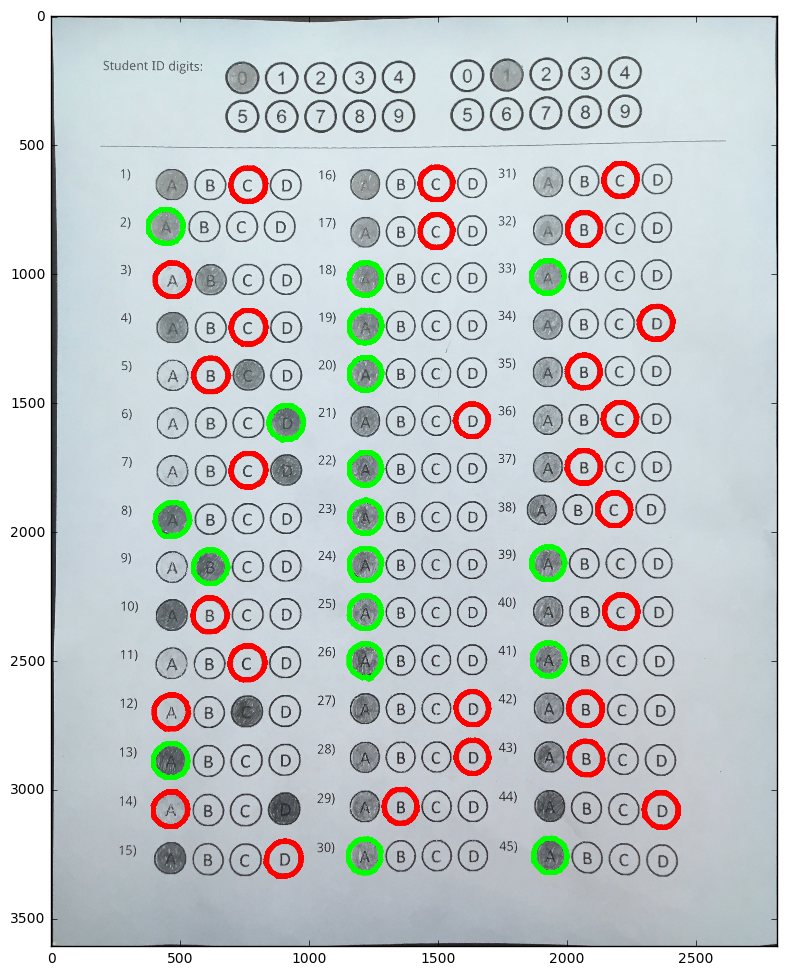

In [22]:
# Show the correct and incorrect answers in green and red, respectively
fig, ax = plt.subplots(figsize=(12,12))
plt.imshow(paper)#,cmap='gray')
plt.show()

In [23]:
# List the question numbers that were answered correctly
sorted(students[student_id])

[2, 6, 8, 9, 13, 18, 19, 20, 22, 23, 24, 25, 26, 30, 33, 39, 41, 45]